# Introduction to Bioinformatics - Project 1

### Needleman-Wunsch algorithm
Władysław Olejnik
9.11.2022

Below we can find the implementation of NW_Alignment class which provides the basic methods and structures required to find the optimal alignment of two DNA sequences.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO


class NW_Alignment:
    """
    Class that provides methods to find the best sequence alignment in
    DNA based on Needleman-Wunsch algorithm.
    """

    # class slots/fields
    __slots__ = (
        "s1",
        "s2",
        "s_dict",
        "s_matrix",
        "dir_matrix",
        "score",
        "alignments",
        "_path_limit",
    )

    def __init__(self, s1, s2, s_dict=None) -> None:
        self.s1 = s1
        self.s2 = s2

        # default score values
        if s_dict is not None:
            self.s_dict = s_dict
        else:
            self.s_dict = {"match": 2, "mismatch": -1, "gap": -2}

        # setting up score and direction matrices
        self.init_s_matrix()
        self.init_dir_matrix()

        self.score = -np.inf  # lowest possible score ;)
        self.alignments = []

        # variable used to limit number of returned optimal paths
        self._path_limit = 0

    def s_function(self, char1: str, char2: str):
        """This function returns a score based on the default
        (or provided by the user) score dictionary."""

        if char1 == "-" or char2 == "-":
            return self.s_dict["gap"]
        elif char1 == char2:
            return self.s_dict["match"]
        else:
            return self.s_dict["mismatch"]

    def init_s_matrix(self):
        """This function initializes the score matrix without calculating it."""
        score_m = np.zeros((len(self.s1) + 1, len(self.s2) + 1))

        # filling first row and first column
        for i in range(1, len(self.s1) + 1):
            score_m[i, 0] = score_m[i - 1, 0] + self.s_function(self.s1[i - 1], "-")

        for j in range(1, len(self.s2) + 1):
            score_m[0, j] = score_m[0, j - 1] + self.s_function(self.s2[j - 1], "-")

        self.s_matrix = score_m

    def init_dir_matrix(self):
        """This function initializes the direction matrix.
        List [left, diagonal, up] as the matrix value represents given directions
        if the variable equals 1."""

        dir_m = [
            [[0, 0, 0] for j in range(len(self.s2) + 1)]
            for i in range(len(self.s1) + 1)
        ]

        for i in range(len(self.s1) + 1):
            for j in range(len(self.s2) + 1):
                if i == 0 and j == 0:
                    dir_m[i][j] = [0, 0, 0]
                elif i == 0:  # first row -> we can only go left
                    dir_m[i][j] = [1, 0, 0]
                elif j == 0:  # first column -> we can only go up
                    dir_m[i][j] = [0, 0, 1]

        self.dir_matrix = dir_m

    def calculate(self):
        """This function evaluates values in the score matrix and saves directions
        in the direction matrix."""

        for i in range(1, len(self.s1) + 1):
            for j in range(1, len(self.s2) + 1):
                # calculating score matrix with score function
                top = self.s_matrix[i - 1, j] + self.s_function(self.s1[i - 1], "-")
                diag = self.s_matrix[i - 1, j - 1] + self.s_function(
                    self.s1[i - 1], self.s2[j - 1]
                )
                left = self.s_matrix[i, j - 1] + self.s_function("-", self.s2[j - 1])

                # maximal score
                m = max(top, diag, left)
                self.s_matrix[i, j] = m

                # saving directions
                dir = [0, 0, 0]
                if top == m:
                    dir[2] = 1
                if diag == m:
                    dir[1] = 1
                if left == m:
                    dir[0] = 1
                self.dir_matrix[i][j] = dir

        self.score = self.s_matrix[len(self.s1)][len(self.s2)]

    def find_path(
        self, x_start, y_start, all_alignments=False, s1_start="", s2_start=""
    ):
        """This function finds paths in the score matrix representing optimal
        sequence alignment. Users can define coordinates from where the
        algorithm starts searching. If parameter all_alignments is True,
        the function will search all possible optimal paths by recursion.
        Parameters s1_start and s2_start are used to provide already-found
        alignments by recursion."""
        str1 = s1_start
        str2 = s2_start
        dim_x = x_start
        dim_y = y_start

        br = False  # recursion flag -> True if recursion started and we exit while loop

        while dim_x + dim_y != 0:  # while we are inside
            # print(dim_x, dim_y, self._path_limit) # simple debug

            dir = self.dir_matrix[dim_x][dim_y]  # direction list
            _sum = sum(dir)

            # when there is only one direction or we are not searching for any other paths
            if _sum == 1 or ((all_alignments is False) and (self._path_limit <= 1)):
                if dir[0] == 1:  # algorithm prioritises left
                    str1 += "-"
                    str2 += self.s2[dim_y - 1]
                    dim_y -= 1
                elif dir[1] == 1:  # then diagonal
                    str1 += self.s1[dim_x - 1]
                    str2 += self.s2[dim_y - 1]
                    dim_x -= 1
                    dim_y -= 1
                else:  # then up
                    str1 += self.s1[dim_x - 1]
                    str2 += "-"
                    dim_x -= 1

            # when we are searching for at least two more paths, recursion occurs
            elif (all_alignments is True) or (self._path_limit > 1):
                # we search in each possible direction

                if dir[0] == 1:
                    path = self.find_path(
                        dim_x,
                        dim_y - 1,
                        all_alignments,
                        str1 + "-",
                        str2 + self.s2[dim_y - 1],
                    )
                    if path is not None:
                        self.alignments.append(path)

                if dir[1] == 1 and (all_alignments is True or self._path_limit >= 1):
                    path = self.find_path(
                        dim_x - 1,
                        dim_y - 1,
                        all_alignments,
                        str1 + self.s1[dim_x - 1],
                        str2 + self.s2[dim_y - 1],
                    )
                    if path is not None:
                        self.alignments.append(path)

                if dir[2] == 1 and (all_alignments is True or self._path_limit >= 1):
                    path = self.find_path(
                        dim_x - 1,
                        dim_y,
                        all_alignments,
                        str1 + self.s1[dim_x - 1],
                        str2 + "-",
                    )
                    if path is not None:
                        self.alignments.append(path)

                # recursion/break flag
                br = True
                break

        if not br:  
            # this instance survived to the end of while loop -> we are returning alignment
            self._path_limit -= 1
            return [str1[::-1], str2[::-1]]
        else:  
            # in this instance recursion occured -> we are returning None
            return None

    def find_alignments(self, all=False, path_limit=1):
        """This function finds optimal alignments. Users can specify a limit of 
        returned optimal paths (the 'all' parameter must be False)."""
        self.alignments = []

        if not all:
            self._path_limit += path_limit
        path = self.find_path(len(self.s1), len(self.s2), all_alignments=all)
        if path is not None:
            self.alignments.append(path)

        self._path_limit = 0

    def print_alignments(self):
        """This function prints formatted alignments."""
        width = 72
        s = ""
        for i, alignment in enumerate(self.alignments):
            s += f"Alignment {i+1}:\n"
            for j in range(0, len(alignment[0]), width):
                s += "{0:<6} {1}\n{3:6} {2}\n\n".format(
                    j + 1, alignment[0][j : j + width], alignment[1][j : j + width], ""
                )
            s += "______\n\n"
        print(s)

    def print_s_matrix(self, plot: bool):
        """This function prints the score matrix as a matrix or 
        colored plot (useful for big sequences)."""
        if plot:
            fig, ax = plt.subplots()
            ax.matshow(self.s_matrix, cmap=plt.cm.Greens)
        else:
            print(self.s_matrix)

We can start testing implemented methods. From the NCBI HomoloGene database, I downloaded a gene that encodes prolactin receptors for humans, chimps, chickens, and dogs. Most accurate results are achieved for humans and chimps. 

For fast computation, we limit the sequence length to 2000.

In [2]:
seq_len = 2000

human = list(SeqIO.parse("data/human.fna", "fasta"))[0].seq[:seq_len]
chimp = list(SeqIO.parse("data/chimp.fna", "fasta"))[0].seq[:seq_len]
# chicken = list(SeqIO.parse("data/chicken.fna", "fasta"))[0].seq[:seq_len]
dog = list(SeqIO.parse("data/dog.fna", "fasta"))[0].seq[:seq_len]

In [3]:
a = NW_Alignment(human, chimp)
a.calculate()
a.find_alignments(all=False)

In [4]:
print(a.score)

3748.0


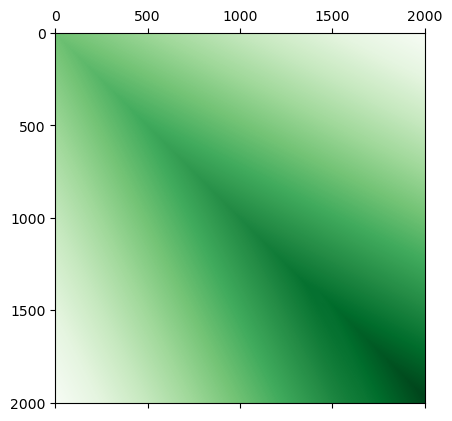

In [5]:
a.print_s_matrix(plot=True)

As we see above, the highest score values in the matrix are almoast precisely in diagonal with a little drift upwards before 1500, 1500 coordinates.

In [6]:
a.print_alignments()

Alignment 1:
1      AGCTTCTTCTCACAGAGCCACCGGGCTGGGGACCGGGGAGCGGAGGCTGAAATCCCCAGACGCCGGTTTTCT
       -GCTTCTTCTCACAGAGCCACCGGGCTGGGGACCGGGGAGCGGAGGCTGAAATCCCCAGACGCCGGTTTTCT

73     GGGCTGGGCTTTCTGCCTTACTCACTCCTTCTCCCTCTTTCTGGATTTTACCGACCGTTCGCGAAACAGCTT
       GGGCTGGGCTTTCTGCCTTACTCACTCCTTCTCCCTCTTTCTGGATTTTACCGACCGTTCGCGAAACAGCTT

145    TCCACACAATGGAGCTTCACGTCCTCGTGCAGGAAGTACTCATCGACTGATGTGGCAGACTTTGCTCCCTGG
       TCCACACAATGGAGCTTCATGTCCTCGTGCAGGAAGTACTCATCGACTGATGTGGCAGACTTTGCTCCCTGG

217    CAAAAGTGAGTACCCATGGCGAGCTGAGGCCGCCTCCCACGGCGCGCGGCAGGGGCTGCGCGGGCGGCCGCT
       CAAAAGTGAGTACCCATGGCGAGCTGAGGCCGCCTCCGACGGCGCGCGGCAGGGGCTGCGCGGGCGGCCGCT

289    GTCCGGGATGCGGGTTCGAGGCCCGCGTGCTGAAGGGGAGAGCGGGGCCACCGGCGCGGGCTCCTGGAGAGA
       CTCCGGGATGCGGGTTCGAGGCCCGCGTGCTGAAGGGGAGAGCGGGGCCACCGGCGCGGGCTCCTGGAGAGA

361    ACGCCAGCCAGGAGCCACAGCCGGCAGCCGGCGGGGAAGCCCGGGATCCGCCCGCCTCCCGCCCGGATGTCC
       ACGCCAGCCAGGAGCCAGAGTCGGCAGCCGGCGGGGAAGCCCGGGATCCGCCCGCCTCCCGCCCGGATGTCC

433    CTTCTCAGAGGGGC

Now we will change score values to force the algorithm to choose gap over mismatch. It has a little sense, but the score matrix is now exciting.

In [7]:
custom_score = {"match": 2, "mismatch": -10, "gap": -1}

b = NW_Alignment(human, dog, s_dict=custom_score)
b.calculate()
b.find_alignments(all=False)

In [8]:
print(b.score)

1416.0


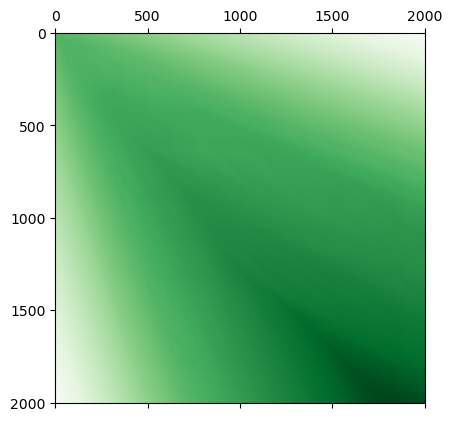

In [9]:
b.print_s_matrix(plot=True)

Because the mismatch score is now -10, the color of the top left corner is brighter - the score is lower than last time. A dark cluster drifted away from the diagonal - it is fuzzy now.

In [10]:
b.print_alignments()

Alignment 1:
1      AGCTTCT--TC--TCACAGAGCCACCGGGCTGGGGACCG-G--G--GAGCGGAG-GCTGAAAT-CCCCAGAC
       --C-TC-CGTCCCTC-C-G-G--ACC--G-T----ACC-CGCTGTCG-GC-G-GCGC-G----GCCCC-G-C

73     GCCGGTTTTCTGGGCTGGGCTTTCTGCCTT-ACTCACTCCTT-C-TCCCTCTTTCTGGATTTTACCGACCGT
       G-C-G----CT---C--GG----C-G----GA-TC-C-CC--GCGT--C-C---C--------A--G--CG-

145    TCGCGAAACAGCTTT-CCACACAATGGAGCTTCACGTCCT-CGTGCAGGAAGTACTCATCGACTGATGTGGC
       -CG-G---CAGC---GCC-CAC---GGA----C-CG----AC---C--G--G----C--CGAC----GT---

217    AGACTTTGCTCCCTGG-CAA--AAGTGAGTAC-CCATGGCGAGCTGAGGCC-GC---CTCCC--ACGGCGCG
       -G-----GCTCCC-GGGC--CCAAGTGAGTA-GCC---GCG-GC---GGCCCGCGGGCT---GGA-GGCG-G

289    -----CGGCA-GGGGCT-GCGCG-G-GCGGCCGCTGTCCGGGA--T-GCGGGT-TCGAGGCCCGCGTG-CTG
       GAGAGCGGC-CGGGGC-AGCGCGCGCGCGG-CGC-G---GGG-GCTCGCGGG-GTCGAGG-CCG-G-GGCT-

361    AAGG-GGA----GAGCGGGGC-CACCGG-CGCGGGCTCCTG-GAGAGAACGC-CAG-C-CAGGA-GCCACAG
       ---GCGG-CCCCG-G-GGGGCTC-CCGGACGC-GG---C-GCGAG-G--CG-GC-GGCGCAGG-TG---CAG

433    CCG-GCAGCCG-GC

Time for a human and hamster insulin comparison.

In [11]:
human_ins = list(SeqIO.parse("data/human_ins.fasta", "fasta"))[0].seq
hamster_ins = list(SeqIO.parse("data/hamster_ins.fasta", "fasta"))[0].seq

In [12]:
c = NW_Alignment(human_ins, hamster_ins)
c.calculate()
c.find_alignments(all=False, path_limit=10)

In [13]:
print(c.score)

166.0


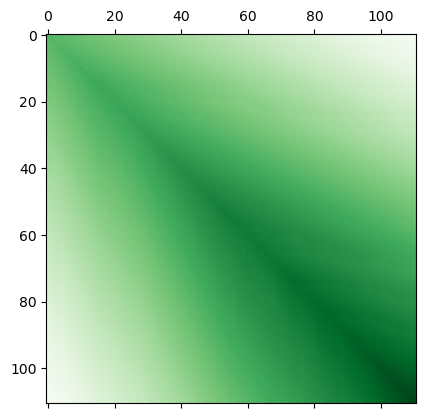

In [14]:
c.print_s_matrix(plot=True)

In [15]:
c.print_alignments()

Alignment 1:
1      MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGP
       MTLWMRLLPLLALLVLWEPNPAQAFVNQHLCGSHLVEALYLVCGERGFFYTPKSRRGVEDPQVAQLELGGGP

73     GAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN
       GADDLQTLALEVAQQKRGIVDQCCTSICSLYQLENYCN

______




In this case, the sequence is almost identical, with few mismatches and zero gaps.

Let's check it with different score values, vastly prioritizing gaps over mismatches.

In [16]:
custom_score = {"match": 2, "mismatch": -10, "gap": -1}

d = NW_Alignment(human_ins, hamster_ins, s_dict=custom_score)
d.calculate()
d.find_alignments(all=False, path_limit=10)

In [17]:
print(d.score)

148.0


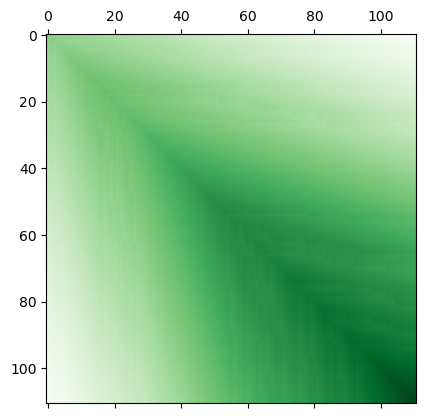

In [18]:
d.print_s_matrix(plot=True)

In [19]:
d.print_alignments()

Alignment 1:
1      MA-LWMRLLPLLALLA-LWG-PD-PAA-AFVNQHLCGSHLVEALYLVCGERGFFYTPKT-RREA--EDL-QV
       M-TLWMRLLPLLALL-VLW-EP-NP-AQAFVNQHLCGSHLVEALYLVCGERGFFYTPK-SRR--GVED-PQV

73     G-QV-ELGGGPGAGS--LQP-LALEGSL--Q-KRGIVE-QCCTSICSLYQLENYCN
       -AQ-LELGGGPGA--DDLQ-TLALE---VAQQKRGIV-DQCCTSICSLYQLENYCN

______

Alignment 2:
1      M-ALWMRLLPLLALLA-LWG-PD-PAA-AFVNQHLCGSHLVEALYLVCGERGFFYTPKT-RREA--EDL-QV
       MT-LWMRLLPLLALL-VLW-EP-NP-AQAFVNQHLCGSHLVEALYLVCGERGFFYTPK-SRR--GVED-PQV

73     G-QV-ELGGGPGAGS--LQP-LALEGSL--Q-KRGIVE-QCCTSICSLYQLENYCN
       -AQ-LELGGGPGA--DDLQ-TLALE---VAQQKRGIV-DQCCTSICSLYQLENYCN

______

Alignment 3:
1      MA-LWMRLLPLLALL-ALWG-PD-PAA-AFVNQHLCGSHLVEALYLVCGERGFFYTPKT-RREA--EDL-QV
       M-TLWMRLLPLLALLV-LW-EP-NP-AQAFVNQHLCGSHLVEALYLVCGERGFFYTPK-SRR--GVED-PQV

73     G-QV-ELGGGPGAGS--LQP-LALEGSL--Q-KRGIVE-QCCTSICSLYQLENYCN
       -AQ-LELGGGPGA--DDLQ-TLALE---VAQQKRGIV-DQCCTSICSLYQLENYCN

______

Alignment 4:
1      M-ALWMRLLPLLALL-ALWG-PD-PAA-AFVNQHLCGSHLVEALYLV

As we see in this case, algorithm is forced to avoid mismatches it results in inserting gap in every single point mutation. It is so important to select proper score values to get reasonable output.